## NCAA March Madness: Sabermetric Spin Second Edition

## Read Me

This is the second version of my NCAA March Madness: Sabermetric Spin series for the March Machine Learning Mania predictions tournament. Special credits go to the following notebook: https://www.kaggle.com/theoviel/ncaa-starter-the-simpler-the-better. You can find the previous version linked at https://www.kaggle.com/code/toshimelonhead/ncaa-march-madness-sabermetric-spin.

I completely rewrote my original version to adapt for the new parts of the 2023 challenge (new loss function, combining men's and women's scores). Also included this year is Elo Ratings, Pythagorean scores, and better visualizations. I figured this should be public because many of these ideas are in other notebooks, but not combined in one spot. Here's to hoping we produce a better result than last season!

## Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import optuna
import re
import sklearn

from optuna.visualization import plot_slice
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import *
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.tree import *
from sklearn.svm import SVC, LinearSVC


import xgboost as xgb
import lightgbm as lgb

## Loading Dataset

In [2]:
DATA_PATH = '../input/march-machine-learning-mania-2023/'

data = dict()
for filename in os.listdir(DATA_PATH):
    print(filename)
    try:
        data[f'{filename[:-4]}'] = pd.read_csv(DATA_PATH + filename, engine='python')
    except UnicodeDecodeError:
        print(filename, 'not loaded')
        continue
    

Conferences.csv
WNCAATourneyDetailedResults.csv
WRegularSeasonCompactResults.csv
MNCAATourneySeedRoundSlots.csv
MRegularSeasonDetailedResults.csv
MNCAATourneyCompactResults.csv
MGameCities.csv
WGameCities.csv
MSeasons.csv
WNCAATourneySlots.csv
MSecondaryTourneyTeams.csv
Cities.csv
SampleSubmission2023.csv
MTeamSpellings.csv
MTeamSpellings.csv not loaded
MRegularSeasonCompactResults.csv
MSecondaryTourneyCompactResults.csv
MMasseyOrdinals_thru_Season2023_Day128.csv
WTeams.csv
MNCAATourneySlots.csv
MNCAATourneySeeds.csv
WNCAATourneyCompactResults.csv
WSeasons.csv
WNCAATourneySeeds.csv
MTeamCoaches.csv
MConferenceTourneyGames.csv
WRegularSeasonDetailedResults.csv
MNCAATourneyDetailedResults.csv
WTeamSpellings.csv
WTeamSpellings.csv not loaded
MTeamConferences.csv
MTeams.csv
WTeamConferences.csv


## Exploratory Data Analysis: First Glance

### Seeds

In [3]:
df_seeds = pd.concat([data['MNCAATourneySeeds'], data['WNCAATourneySeeds']], ignore_index=True)

def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df_seeds['Seed'] = df_seeds['Seed'].apply(treat_seed)
df_seeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4098 entries, 0 to 4097
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Season  4098 non-null   int64
 1   Seed    4098 non-null   int64
 2   TeamID  4098 non-null   int64
dtypes: int64(3)
memory usage: 96.2 KB


In [4]:
data['MTeams'].to_csv('MTeams.csv')

In [5]:
df_seeds.tail() # We have 2023 seeds now, huzzah!

,Season,Seed,TeamID
4093,2023,12,3405
4094,2023,13,3387
4095,2023,14,3241
4096,2023,15,3436
4097,2023,16,3151


### Season Results

In [6]:
men_season = data['MRegularSeasonDetailedResults']
women_season = data['WRegularSeasonDetailedResults']
men_season['Gender'] = 1
women_season['Gender'] = 0 # It's boolean, not bias
df_season_results = pd.concat([men_season, women_season])
df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

df_season_results.head()
df_season_results[['Season', 'WTeamID', 'LTeamID']] = df_season_results[['Season', 'WTeamID', 'LTeamID']].astype(str)

In [7]:
df_teams = pd.concat([data['MTeams'][['TeamID', 'TeamName']], data['WTeams']], axis=0)

In [8]:
df_teams.head()

,TeamID,TeamName
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


### Tourney Results

In [9]:
men_tourney = data['MNCAATourneyDetailedResults']
women_tourney = data['WNCAATourneyDetailedResults']
men_tourney['Gender'] = 1
women_tourney['Gender'] = 0 
df_tourney_results = pd.concat([men_tourney, women_tourney])
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
df_tourney_results[['Season', 'WTeamID', 'LTeamID']] = df_tourney_results[['Season', 'WTeamID', 'LTeamID']].astype(str)
df_tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Gender
0,2003,134,1421,92,1411,84,32,69,11,29,...,14,31,17,28,16,15,5,0,22,1
1,2003,136,1112,80,1436,51,31,66,7,23,...,7,7,8,26,12,17,10,3,15,1
2,2003,136,1113,84,1272,71,31,59,6,14,...,14,21,20,22,11,12,2,5,18,1
3,2003,136,1141,79,1166,73,29,53,3,7,...,12,17,14,17,20,21,6,6,21,1
4,2003,136,1143,76,1301,74,27,64,7,20,...,15,20,10,26,16,14,5,8,19,1


## Compute Wins, Losses, Scoring Margin, Pythagorean W/L

### Wins and Losses

In [10]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"}).fillna(0)

num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"}).fillna(0)


In [11]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')

df_features_season['NumWins'] = df_features_season['NumWins'].fillna(0)
df_features_season['NumLosses'] = df_features_season['NumLosses'].fillna(0)


df_features_season['WinPct'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])

In [12]:
df_features_season.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12135 entries, 0 to 12134
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Season     12135 non-null  object 
 1   TeamID     12135 non-null  object 
 2   NumWins    12135 non-null  float64
 3   NumLosses  12135 non-null  float64
 4   WinPct     12135 non-null  float64
dtypes: float64(3), object(2)
memory usage: 568.8+ KB


### Scoring Margin

In [13]:
df_season_results['ScoreMargin'] = df_season_results['WScore'] - df_season_results['LScore']

win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
win_score_margin = win_score_margin[['Season', 'WTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgWinningScoreMargin", "WTeamID": "TeamID"}).fillna(0)

lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
lose_score_margin = lose_score_margin[['Season', 'LTeamID', 'ScoreMargin']].rename(columns={"ScoreMargin": "AvgLosingScoreMargin", "LTeamID": "TeamID"}).fillna(0)

df_features_season = df_features_season.merge(win_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(lose_score_margin, on=['Season', 'TeamID'], how='left')
df_features_season.fillna(0, inplace=True) # Takes care of undefeated teams


df_features_season['AvgScoringMargin'] = (
    (df_features_season['NumWins'] * df_features_season['AvgWinningScoreMargin'] - 
    df_features_season['NumLosses'] * df_features_season['AvgLosingScoreMargin'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

/tmp/ipykernel_32/4115899744.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
/tmp/ipykernel_32/4115899744.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()


### Points Scored and Allowed

In [14]:
win_points_scored = df_season_results.groupby(['Season', 'WTeamID'])['WScore'].sum().reset_index().rename(columns={"WScore": "WPointsScored", "WTeamID": "TeamID"})
lose_points_scored = df_season_results.groupby(['Season', 'LTeamID'])['LScore'].sum().reset_index().rename(columns={"LScore": "LPointsScored", "LTeamID": "TeamID"})

win_points_allowed = df_season_results.groupby(['Season', 'WTeamID'])['LScore'].sum().reset_index().rename(columns={"LScore": "WPointsAllowed", "WTeamID": "TeamID"})
lose_points_allowed = df_season_results.groupby(['Season', 'LTeamID'])['WScore'].sum().reset_index().rename(columns={"WScore": "LPointsAllowed", "LTeamID": "TeamID"})

In [15]:
total_points_scored = win_points_scored.merge(lose_points_scored, how='outer').fillna(0)
total_points_scored['PointsScored'] = total_points_scored['WPointsScored'] + total_points_scored['LPointsScored']

total_points_allowed = win_points_allowed.merge(lose_points_allowed, how='outer').fillna(0)
total_points_allowed['PointsAllowed'] = total_points_allowed['WPointsAllowed'] + total_points_allowed['LPointsAllowed']

In [16]:
total_points_allowed.head()

,Season,TeamID,WPointsAllowed,LPointsAllowed,PointsAllowed
0,2003,1102,638.0,958.0,1596.0
1,2003,1103,1019.0,1091.0,2110.0
2,2003,1104,1046.0,774.0,1820.0
3,2003,1105,465.0,1528.0,1993.0
4,2003,1106,753.0,1032.0,1785.0


### Pythagorean W/L

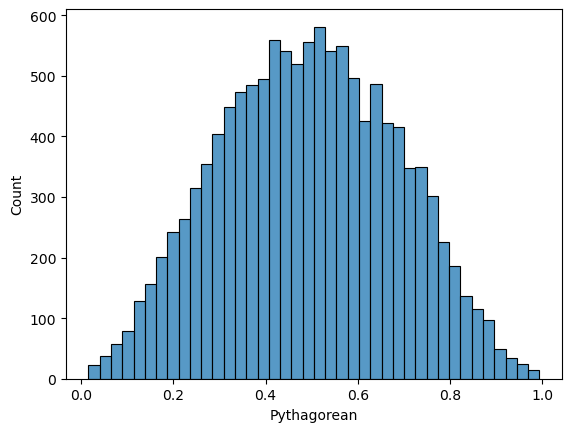

In [17]:
total_points = total_points_scored.merge(total_points_allowed, how='outer')
total_points['Pythagorean'] = 1 / (1 + (total_points['PointsAllowed'] / total_points['PointsScored']) ** 8)

# The 8 is arbitrary (KenPom I think uses 11.5). I wanted something that would create a nice bell shaped curve like below.
sns.histplot(total_points['Pythagorean'])
plt.show()

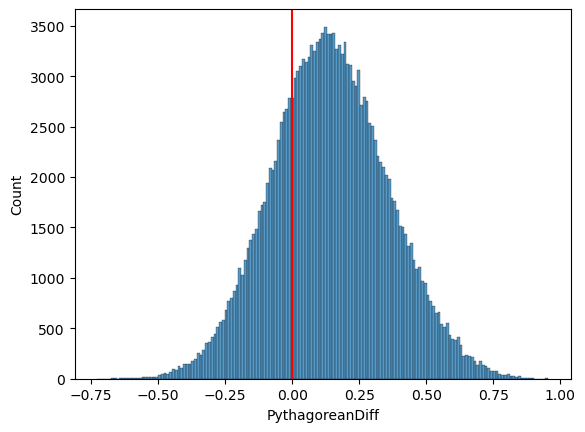

In [18]:
df_season_condensed = df_season_results[['Season', 'WTeamID', 'LTeamID']].copy()

df_season_condensed_pyth = df_season_condensed.merge(total_points[['Season', 'TeamID', 'Pythagorean']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left', suffixes=[None, "W"])
df_season_condensed_pyth = df_season_condensed_pyth.merge(total_points[['Season', 'TeamID', 'Pythagorean']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left', suffixes=[None, 'L'])
df_season_condensed_pyth['PythagoreanDiff'] = df_season_condensed_pyth['Pythagorean'] - df_season_condensed_pyth['PythagoreanL']

sns.histplot(df_season_condensed_pyth['PythagoreanDiff'])
plt.axvline(0, color='red')
plt.show()

### Team Trend Over Time: The Tennessee Correction

This corrects for team changes over time such as injuries late in the season. It also rewards teams that are playing well compared to their record heading into the tournament.

In [19]:
# Find where to split the number of games into 75-25 split.
split = np.percentile(df_season_results['DayNum'], 75)
first_three_quarters = df_season_results[df_season_results['DayNum'] < split].copy()
fourth_quarter = df_season_results[df_season_results['DayNum'] >= split].copy()

In [20]:
def pythagorean(df, exponent=8):
    """Computes the pythagorean percentage given a number of games played in the season."""
    
    win_points_scored = df.groupby(['Season', 'WTeamID'])['WScore'].sum().reset_index().rename(columns={"WScore": "WPointsScored", "WTeamID": "TeamID"})
    lose_points_scored = df.groupby(['Season', 'LTeamID'])['LScore'].sum().reset_index().rename(columns={"LScore": "LPointsScored", "LTeamID": "TeamID"})

    win_points_allowed = df.groupby(['Season', 'WTeamID'])['LScore'].sum().reset_index().rename(columns={"LScore": "WPointsAllowed", "WTeamID": "TeamID"})
    lose_points_allowed = df.groupby(['Season', 'LTeamID'])['WScore'].sum().reset_index().rename(columns={"WScore": "LPointsAllowed", "LTeamID": "TeamID"})

    total_points_scored = win_points_scored.merge(lose_points_scored, how='outer').fillna(0)
    total_points_scored['PointsScored'] = total_points_scored['WPointsScored'] + total_points_scored['LPointsScored']

    total_points_allowed = win_points_allowed.merge(lose_points_allowed, how='outer').fillna(0)
    total_points_allowed['PointsAllowed'] = total_points_allowed['WPointsAllowed'] + total_points_allowed['LPointsAllowed']

    total_points = total_points_scored.merge(total_points_allowed, how='outer')
    total_points['Pythagorean'] = 1 / (1 + (total_points['PointsAllowed'] / total_points['PointsScored']) ** 8)

    # The 8 is arbitrary (KenPom I think uses 11.5). I wanted something that would create a nice bell shaped curve like below.
    return total_points

In [21]:
pyth_first_three_quarters = pythagorean(first_three_quarters)
pyth_fourth_quarter = pythagorean(fourth_quarter)
pyth_by_period = pyth_first_three_quarters.merge(pyth_fourth_quarter,
                                    on=['Season', 'TeamID'], 
                                    suffixes=['_A', '_B'])\
                                    .set_index(['Season', 'TeamID'])[['Pythagorean_A', 'Pythagorean_B']]\
                                    .sort_values(['Season', 'TeamID'])

pyth_by_period.columns = ['Early', 'Late']
pyth_by_period['Trend'] = pyth_by_period['Late'] - pyth_by_period['Early']
pyth_by_period['Trend'].fillna(0)

Season  TeamID
2003    1102     -0.211204
        1103      0.072055
        1104      0.024132
        1105      0.234979
        1106     -0.114556
                    ...   
2023    3473      0.006689
        3474     -0.113257
        3475      0.096805
        3476      0.356930
        3477      0.096658
Name: Trend, Length: 12116, dtype: float64

## Sabermetrics

In [22]:
sabermetrics = pd.DataFrame()
sabermetrics_differences = pd.DataFrame()

sabermetrics['Season'] = df_season_results['Season']
sabermetrics['WTeamID'] = df_season_results['WTeamID']
sabermetrics['LTeamID'] = df_season_results['LTeamID']

sabermetrics_differences['Season'] = df_season_results['Season']
sabermetrics_differences['WTeamID'] = df_season_results['WTeamID']
sabermetrics_differences['LTeamID'] = df_season_results['LTeamID']

# Number of Possessions
sabermetrics['WPossessions'] = (df_season_results['WFGA'] - df_season_results['WOR']) + df_season_results['WTO'] + .44 * df_season_results['WFTA']
sabermetrics['LPossessions'] = (df_season_results['LFGA'] - df_season_results['LOR']) + df_season_results['LTO'] + .44 * df_season_results['LFTA']

df_season_results['WPossessions'] = sabermetrics['WPossessions']
df_season_results['LPossessions'] = sabermetrics['LPossessions']

# Points Per Possession
sabermetrics['WPtsPerPoss'] = df_season_results['WScore'] / df_season_results['WPossessions']
sabermetrics['LPtsPerPoss'] = df_season_results['LScore'] / df_season_results['LPossessions']

# Opponent Points Per Possession:
sabermetrics['WOPtsPerPoss'] = df_season_results['LScore'] / df_season_results['LPossessions'] # O for 'opponent'
sabermetrics['LOPtsPerPoss'] = df_season_results['WScore'] / df_season_results['WPossessions']

# Effective Field Goal Percentage
sabermetrics['WEffectiveFGPct'] = ((df_season_results['WScore'] - df_season_results['WFTM']) / 2) / df_season_results['WFGA']
sabermetrics['LEffectiveFGPct'] = ((df_season_results['LScore'] - df_season_results['LFTM']) / 2) / df_season_results['LFGA']

# Percentage of Field Goals Assisted
sabermetrics['WAssistRate'] = df_season_results['WAst'] / df_season_results['WFGM']
sabermetrics['LAssistRate'] = df_season_results['LAst'] / df_season_results['LFGM']

# Rebound Percentage
sabermetrics['WReboundPct'] = (df_season_results['WDR'] + df_season_results['WOR']) / (df_season_results['LFGA'] - df_season_results['LFGM'])
sabermetrics['LReboundPct'] = (df_season_results['LDR'] + df_season_results['LOR']) / (df_season_results['WFGA'] - df_season_results['WFGM'])

# Steal Block Foul Ratio (the plus 10's are for getting rid of infinity and 0 bounds)
sabermetrics['WStealBlockFoul'] = (df_season_results['WStl'] + df_season_results['WBlk'] + 10) / (df_season_results['WPF'] + 10)
sabermetrics['LStealBlockFoul'] = (df_season_results['LStl'] + df_season_results['LBlk'] + 10) / (df_season_results['LPF'] + 10)

# Turnover Rate
sabermetrics['WTORate'] = df_season_results['WTO'] / df_season_results['WPossessions']
sabermetrics['LTORate'] = df_season_results['LTO'] /  df_season_results['LPossessions']

# Percentage of Shots Beyond the Arc
sabermetrics['WBArcPct'] = df_season_results['WFGA3'] / df_season_results['WFGA']
sabermetrics['LBArcPct'] = df_season_results['LFGA3'] /  df_season_results['LFGA']

# Free Throw Rate
sabermetrics['WFTRate'] = df_season_results['WFTA'] / df_season_results['WFGA']
sabermetrics['LFTRate'] = df_season_results['LFTA'] /  df_season_results['LFGA']

# Free Throw Percentage
sabermetrics['WFTPct'] = df_season_results['WFTM'] / df_season_results['WFTA']
sabermetrics['LFTPct'] = df_season_results['LFTM'] / df_season_results['LFTA']

In [23]:
# Check for missing values
sabermetrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178417 entries, 0 to 70782
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Season           178417 non-null  object 
 1   WTeamID          178417 non-null  object 
 2   LTeamID          178417 non-null  object 
 3   WPossessions     178417 non-null  float64
 4   LPossessions     178417 non-null  float64
 5   WPtsPerPoss      178417 non-null  float64
 6   LPtsPerPoss      178417 non-null  float64
 7   WOPtsPerPoss     178417 non-null  float64
 8   LOPtsPerPoss     178417 non-null  float64
 9   WEffectiveFGPct  178417 non-null  float64
 10  LEffectiveFGPct  178417 non-null  float64
 11  WAssistRate      178417 non-null  float64
 12  LAssistRate      178417 non-null  float64
 13  WReboundPct      178417 non-null  float64
 14  LReboundPct      178417 non-null  float64
 15  WStealBlockFoul  178417 non-null  float64
 16  LStealBlockFoul  178417 non-null  float

In [24]:
# Fill in missing values
sabermetrics['WStealBlockFoul'].fillna(df_season_results['WStl'] + df_season_results['WBlk'], inplace=True)
sabermetrics.fillna(0, inplace=True)

# Differences (used for plotting below)
sabermetrics['PtsPerPossDiff'] = sabermetrics['WPtsPerPoss'] - sabermetrics['LPtsPerPoss']
sabermetrics['OPtsPerPossDiff'] = sabermetrics['WOPtsPerPoss'] - sabermetrics['LOPtsPerPoss'] # O for opponent
sabermetrics['EffectiveFGPctDiff'] = sabermetrics['WEffectiveFGPct'] - sabermetrics['LEffectiveFGPct']
sabermetrics['AssistRateDiff'] = sabermetrics['WAssistRate'] - sabermetrics['LAssistRate']
sabermetrics['ReboundPctDiff'] = sabermetrics['WReboundPct'] - sabermetrics['LReboundPct']
sabermetrics['StealBlockFoulDiff'] = sabermetrics['WStealBlockFoul'] - sabermetrics['LStealBlockFoul']
sabermetrics['TORateDiff'] = sabermetrics['WTORate'] - sabermetrics['LTORate']
sabermetrics['BArcPctDiff'] = sabermetrics['WBArcPct'] - sabermetrics['LBArcPct']
sabermetrics['FTRateDiff'] = sabermetrics['WFTRate'] - sabermetrics['LFTRate']
sabermetrics['FTPctDiff'] = sabermetrics['WFTPct'] - sabermetrics['LFTPct']

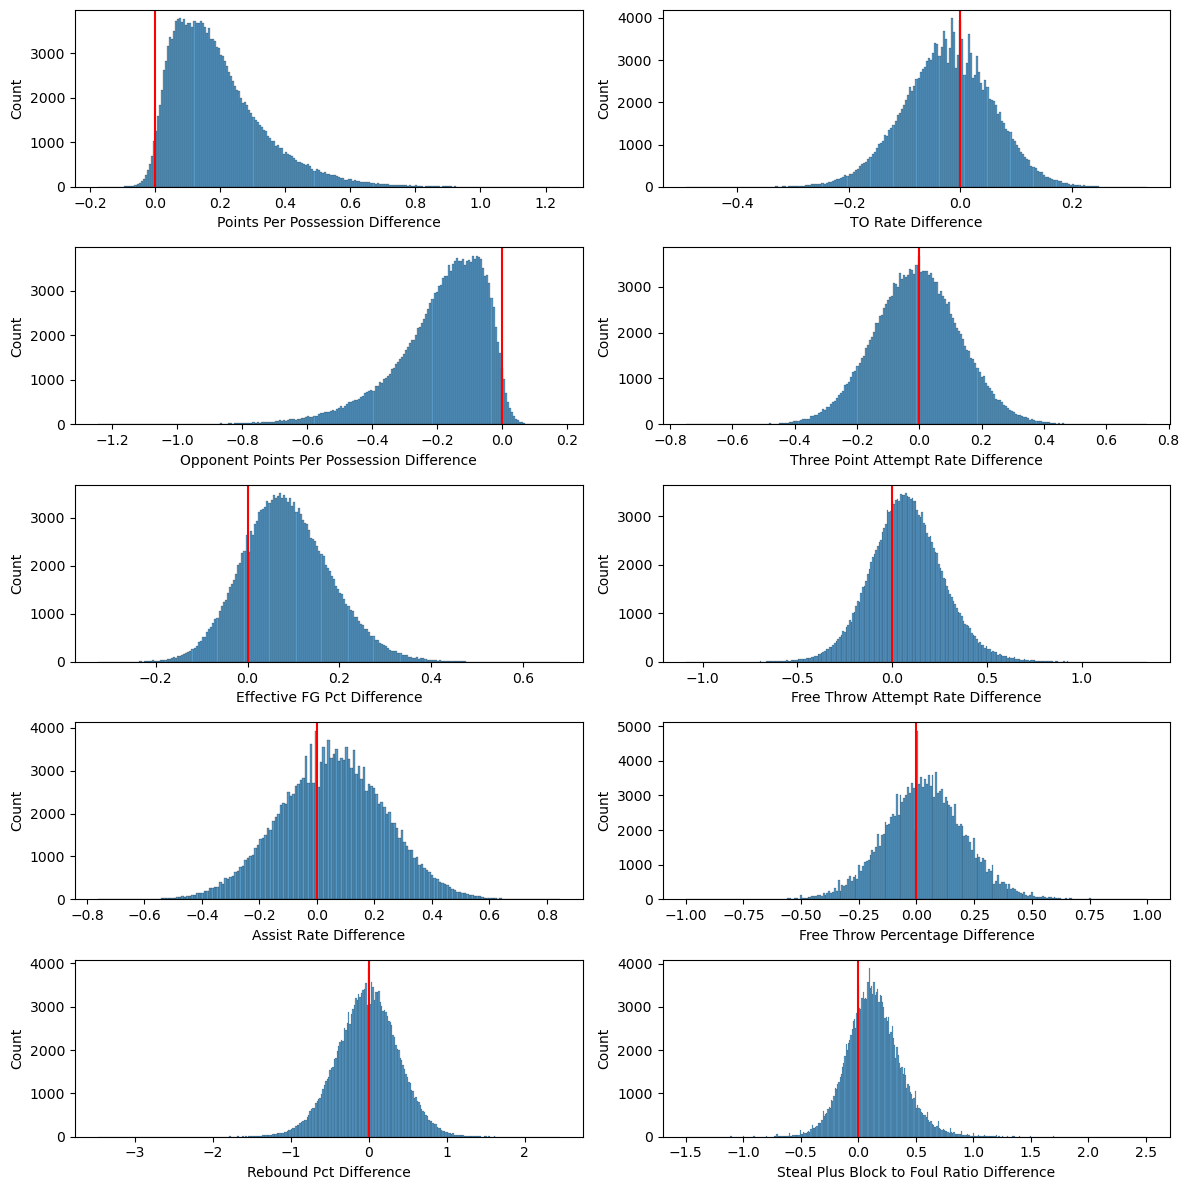

In [25]:
figs, axs = plt.subplots(nrows=5, ncols=2, squeeze=False, figsize=(12, 12))

sns.histplot(sabermetrics['PtsPerPossDiff'], ax=axs[0, 0])
axs[0, 0].set_xlabel('Points Per Possession Difference')
axs[0, 0].axvline(0, color='red')

sns.histplot(sabermetrics['OPtsPerPossDiff'], ax=axs[1, 0])
axs[1, 0].set_xlabel('Opponent Points Per Possession Difference')
axs[1, 0].axvline(0, color='red')

sns.histplot(sabermetrics['EffectiveFGPctDiff'], ax=axs[2, 0])
axs[2, 0].set_xlabel('Effective FG Pct Difference')
axs[2, 0].axvline(0, color='red')

sns.histplot(sabermetrics['AssistRateDiff'], ax=axs[3, 0])
axs[3, 0].set_xlabel('Assist Rate Difference')
axs[3, 0].axvline(0, color='red')

sns.histplot(sabermetrics['ReboundPctDiff'], ax=axs[4, 0])
axs[4, 0].set_xlabel('Rebound Pct Difference')
axs[4, 0].axvline(0, color='red')

sns.histplot(sabermetrics['TORateDiff'], ax=axs[0, 1])
axs[0, 1].set_xlabel('TO Rate Difference')
axs[0, 1].axvline(0, color='red')

sns.histplot(sabermetrics['BArcPctDiff'], ax=axs[1, 1])
axs[1, 1].set_xlabel('Three Point Attempt Rate Difference')
axs[1, 1].axvline(0, color='red')

sns.histplot(sabermetrics['FTRateDiff'], ax=axs[2, 1])
axs[2, 1].set_xlabel('Free Throw Attempt Rate Difference')
axs[2, 1].axvline(0, color='red')

sns.histplot(sabermetrics['FTPctDiff'], ax=axs[3, 1])
axs[3, 1].set_xlabel('Free Throw Percentage Difference')
axs[3, 1].axvline(0, color='red')

sns.histplot(sabermetrics['StealBlockFoulDiff'], ax=axs[4, 1])
axs[4, 1].set_xlabel('Steal Plus Block to Foul Ratio Difference')
axs[4, 1].axvline(0, color='red')
plt.tight_layout()
plt.show()

In [26]:
winning_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'W']]
losing_columns = sabermetrics[[col for col in sabermetrics.columns if col[0] == 'L']]

winning_columns.loc[:, 'Season'] = sabermetrics['Season']
losing_columns.loc[:, 'Season'] = sabermetrics['Season']

winning_sabermetrics = winning_columns.groupby(['Season', 'WTeamID']).mean()
losing_sabermetrics = losing_columns.groupby(['Season', 'LTeamID']).mean()

winning_sabermetrics = winning_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumWins']], left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'WTeamID']) \
                        .drop(['TeamID'], axis=1)

losing_sabermetrics = losing_sabermetrics \
                        .reset_index() \
                        .merge(df_features_season[['Season', 'TeamID', 'NumLosses']], left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left') \
                        .set_index(['Season', 'LTeamID']) \
                        .drop(['TeamID'], axis=1)

weighted_sabermetrics_wins = winning_sabermetrics[[col for col in winning_sabermetrics.columns if col[0] == 'W']].multiply(winning_sabermetrics['NumWins'], axis=0)
weighted_sabermetrics_losses = losing_sabermetrics[[col for col in losing_sabermetrics.columns if col[0] == 'L']].multiply(losing_sabermetrics['NumLosses'], axis=0)

weighted_sabermetrics = pd.DataFrame()
weighted_sabermetrics['Possessions'] = (weighted_sabermetrics_wins['WPossessions'] + weighted_sabermetrics_losses['LPossessions']) /  \
                                       (winning_sabermetrics['NumWins'] + losing_sabermetrics['NumLosses'])

combined_df = winning_sabermetrics.reset_index().merge(losing_sabermetrics.reset_index(), left_on=['WTeamID', 'Season'], right_on=['LTeamID', 'Season'], how='outer')

def weighted_metric(metric, df=combined_df.set_index(['Season', 'WTeamID'], inplace=True)):
    """Computes the weighted stat from winning and losing metric"""
        
    weighted_df = ((combined_df[f'W{metric}'].mul(combined_df['NumWins']) + combined_df[f'L{metric}'].mul(combined_df['NumLosses'])) \
    / (combined_df['NumWins'] + combined_df['NumLosses']))
    return weighted_df


combined_df.reset_index(inplace=True)
combined_df['WTeamID'].fillna(combined_df['LTeamID'], inplace=True)
combined_df['LTeamID'].fillna(combined_df['WTeamID'], inplace=True)
combined_df.set_index(['Season', 'WTeamID'], inplace=True)
combined_df.fillna(0, inplace=True)

metrics_list = ['PtsPerPoss', 'OPtsPerPoss', 'EffectiveFGPct', 'AssistRate', 'ReboundPct', 'TORate', 'BArcPct', 'FTRate', 'FTPct', 'StealBlockFoul']
season_sabermetrics = pd.concat([weighted_metric(metric) for metric in metrics_list], axis=1)
season_sabermetrics.columns=metrics_list

season_sabermetrics.index.columns = ['Season', 'TeamID']


/tmp/ipykernel_32/4054525028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_columns.loc[:, 'Season'] = sabermetrics['Season']
/tmp/ipykernel_32/4054525028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losing_columns.loc[:, 'Season'] = sabermetrics['Season']


## Elo Ratings

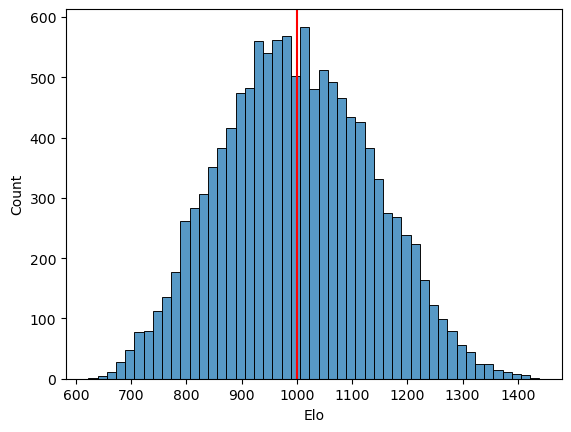

In [27]:
def update_elo_scores(df, scores_dict, k=40):
    for index, row in df.iterrows():
        player1, player2 = str(row['WTeamID']), str(row['LTeamID'])
        if player1 not in scores_dict:
            scores_dict[player1] = 1000
        if player2 not in scores_dict:
            scores_dict[player2] = 1000
        score1, score2 = scores_dict[player1], scores_dict[player2]
        expected_score1 = 1 / (1 + 10 ** ((score2 - score1) / 400))
        expected_score2 = 1 / (1 + 10 ** ((score1 - score2) / 400))
        scores_dict[player1] = score1 + k * (1 - expected_score1)
        scores_dict[player2] = score2 + k * (0 - expected_score2)
    return scores_dict

all_seasons = dict()
scores_dict = dict()

for season in range(2003, 2024):
    df_season_condensed_year = df_season_condensed[df_season_condensed['Season'] == str(season)]
    scores_dict = update_elo_scores(df_season_condensed_year, scores_dict)
    all_seasons[str(season)] = scores_dict
    scores_dict = dict() # Reset dict for next season
    
elo_scores = pd.DataFrame(all_seasons)
elo_scores_unstacked = elo_scores.unstack().reset_index()
elo_scores_unstacked.columns = ['Season', 'TeamID', 'Elo']

sns.histplot(elo_scores_unstacked['Elo'])
plt.axvline(1000, color='red')
plt.show()

In [28]:
elo_scores.head()

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1104,1066.352822,1117.192400,1196.320838,1099.885431,1083.711886,1040.515817,1079.725499,1051.601197,1156.823163,1125.215250,...,994.814024,1040.146748,1067.584697,1090.089439,1092.795937,1052.564581,1037.867367,1245.360374,1088.635389,1301.621055
1328,1262.723380,1100.921439,1212.741831,1150.580989,1043.744339,1163.539593,1234.079198,969.210067,1018.275937,988.632843,...,1180.616963,1192.376473,1217.436440,959.744004,1061.638268,1079.193130,1114.540306,1057.731395,1095.706827,1031.105121
1272,1212.007947,1165.173812,1088.778385,1304.826501,1310.293714,1358.455688,1344.472188,1154.151009,1187.071640,1251.833089,...,1163.509130,1068.297297,1056.439823,1032.698001,1108.006837,1150.623770,1121.892084,1125.998671,1199.199613,1246.292829
1393,1239.848722,1198.545192,1244.221429,1193.599467,1161.282430,1095.629016,1226.076203,1263.604083,1226.313108,1339.709584,...,1221.752755,1089.287674,1077.730217,1104.969092,1095.869576,1112.227738,1073.554919,1107.021698,1034.966942,1025.860047
1266,1232.764096,1061.233718,1043.880131,1138.236674,1176.709557,1171.019228,1158.109948,1181.793770,1104.786281,1218.383540,...,1063.810996,972.356159,1095.161335,1120.589482,1120.829085,1154.145841,1068.036717,1011.632105,1097.954684,1290.629871


## Opponent Elo Ratings

In [29]:
df_teams.head()

,TeamID,TeamName
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [30]:
all_opponent_elos = dict() # The dataframe to hold all Elo scores
all_opponent_elos_df = pd.DataFrame() # The final dataframe

for season in range(2003, 2024):
    df_season_condensed_year = df_season_condensed[df_season_condensed['Season'] == str(season)].reset_index(drop=True)
    df_season_condensed_year['WElo'] = df_season_condensed_year.merge(elo_scores[str(season)], left_on=['WTeamID'], right_index=True, how='inner')[str(season)]
    df_season_condensed_year['LElo'] = df_season_condensed_year.merge(elo_scores[str(season)], left_on=['LTeamID'], right_index=True, how='inner')[str(season)]
    opponent_elo_dicts = dict()
    for game in df_season_condensed_year.iterrows():
        # Create dictionary for each team to hold opponent Elo ratings
        
        if game[1]['WTeamID'] not in opponent_elo_dicts.keys():
            opponent_elo_dicts[str(game[1]['WTeamID'])] = []
        if game[1]['LTeamID'] not in opponent_elo_dicts.keys():
            opponent_elo_dicts[str(game[1]['LTeamID'])] = []
            
        # Append opposing team's Elo score to dictionary
        opponent_elo_dicts[str(game[1]['WTeamID'])].append(game[1]['LElo'])
        opponent_elo_dicts[str(game[1]['LTeamID'])].append(game[1]['WElo'])       
    
    # Generate the mean of each dictionary of opponent Elos
    opponent_elo_scores = dict()
    
    for team in opponent_elo_dicts:
        opponent_elo_scores[team] =  np.mean(opponent_elo_dicts[team])
        opponent_elos = pd.DataFrame.from_dict(opponent_elo_scores, orient='index', columns = ['OElo'])

    all_opponent_elos[str(season)] = opponent_elos
    # Loop through the dictionary and create a new DataFrame for each key-value pair
    
    for team, opponent_elo in all_opponent_elos[str(season)].items():
        temp_df = pd.DataFrame(opponent_elo, columns=["Season", team])
        temp_df.loc[:, "Season"] = str(season) 
    
    # Append the new DataFrame to the final DataFrame
    all_opponent_elos_df = pd.concat([all_opponent_elos_df, temp_df], axis=0)
        

In [31]:
all_opponent_elos_df.reset_index(inplace=True)
all_opponent_elos_df.columns=['TeamID', 'Season', 'OElo']

In [32]:
all_opponent_elos_df.head()

,TeamID,Season,OElo
0,1104,2003,1078.046651
1,1328,2003,1083.772782
2,1272,2003,1028.423521
3,1393,2003,1051.243939
4,1266,2003,1047.691093


## Merge the datasets together

In [33]:
pyth_trimmed = pd.DataFrame(total_points.set_index(['Season', 'TeamID'])['Pythagorean'])
elo_trimmed = elo_scores_unstacked.set_index(['Season', 'TeamID'])
df_features_season_trimmed = df_features_season.set_index(['Season', 'TeamID'])[['WinPct', 'AvgScoringMargin']]
opponent_elo_trimmed = all_opponent_elos_df.set_index(['Season', 'TeamID'])
pyth_by_period_trimmed = pyth_by_period['Trend']
all_statistics = pd.concat([pyth_trimmed, elo_trimmed, df_features_season_trimmed, season_sabermetrics, \
                            opponent_elo_trimmed, pyth_by_period_trimmed], axis=1)

In [34]:
all_statistics[all_statistics['Trend'].isna()]

Pythagorean         Elo    WinPct  AvgScoringMargin  PtsPerPoss  \
Season                                                                         
2008   1223     0.140333  865.793382  0.100000        -17.800000    0.952993   
2021   1224     0.232550  962.231961  0.250000        -11.750000    0.993621   
       1263     0.173486  923.484324  0.222222        -11.444444    0.824846   
       3127     0.327901  941.846032  0.312500         -5.062500    0.791702   
       3178     0.128811  827.607404  0.071429        -15.500000    0.792357   
...                  ...         ...       ...               ...         ...   
2023   1289          NaN         NaN       NaN               NaN         NaN   
       1366          NaN         NaN       NaN               NaN         NaN   
       1445          NaN         NaN       NaN               NaN         NaN   
       3147          NaN         NaN       NaN               NaN         NaN   
       3366          NaN         NaN       NaN               NaN         NaN   

             OPtsPerPoss  EffectiveFGPct  AssistRate  ReboundPct    TORate  \
Season                                                                       
2008   1223     1.189663        0.490523    0.468305    0.978475  0.231722   
2021   1224     1.135084        0.509381    0.663096    0.862179  0.175842   
       1263     0.982281        0.451328    0.625639    0.950034  0.237420   
       3127     0.852901        0.423349    0.453316    0.934660  0.243229   
       3178     1.019108        0.406173    0.548060    0.886928  0.254953   
...                  ...             ...         ...         ...       ...   
2023   1289          NaN             NaN         NaN         NaN       NaN   
       1366          NaN             NaN         NaN         NaN       NaN   
       1445          NaN             NaN         NaN         NaN       NaN   
       3147          NaN             NaN         NaN         NaN       NaN   
       3366          NaN             NaN         NaN         NaN       NaN   

              BArcPct    FTRate     FTPct  StealBlockFoul         OElo  Trend  
Season                                                                         
2008   1223  0.318489  0.277150  0.744920        0.650716  1010.687638    NaN  
2021   1224  0.453480  0.386295  0.652010        2.050000  1054.470324    NaN  
       1263  0.446881  0.284515  0.549657        2.011111   991.012146    NaN  
       3127  0.252238  0.205523  0.505643        0.885387   993.439603    NaN  
       3178  0.361242  0.331751  0.717375        1.033018  1004.568416    NaN  
...               ...       ...       ...             ...          ...    ...  
2023   1289       NaN       NaN       NaN             NaN          NaN    NaN  
       1366       NaN       NaN       NaN             NaN          NaN    NaN  
       1445       NaN       NaN       NaN             NaN          NaN    NaN  
       3147       NaN       NaN       NaN             NaN          NaN    NaN  
       3366       NaN       NaN       NaN             NaN          NaN    NaN  

[3235 rows x 16 columns]

In [35]:
winning_tourney_results = df_tourney_results[['Season', 'WTeamID', 'LTeamID']].merge(all_statistics, 
                                                                                     left_on=['Season', 'WTeamID'], 
                                                                                     right_index=True, how='left')
losing_tourney_results = df_tourney_results[['Season', 'WTeamID', 'LTeamID']].merge(all_statistics, 
                                                                                    left_on=['Season', 'LTeamID'], 
                                                                                    right_index=True, how='left')

In [36]:
combined_tourney_results = pd.merge(left=winning_tourney_results, 
                                    right=losing_tourney_results, 
                                    on=['Season', 'WTeamID', 'LTeamID'], 
                                    suffixes=['_W', '_L'])

df_seeds[['Season', 'TeamID']] = df_seeds[['Season', 'TeamID']].astype(str)

combined_tourney_results = pd.merge(
    combined_tourney_results,
    df_seeds,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'Seed_W'})

combined_tourney_results = pd.merge(
    combined_tourney_results, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'Seed_L'})

combined_tourney_results.columns

Index(['Season', 'WTeamID', 'LTeamID', 'Pythagorean_W', 'Elo_W', 'WinPct_W',
       'AvgScoringMargin_W', 'PtsPerPoss_W', 'OPtsPerPoss_W',
       'EffectiveFGPct_W', 'AssistRate_W', 'ReboundPct_W', 'TORate_W',
       'BArcPct_W', 'FTRate_W', 'FTPct_W', 'StealBlockFoul_W', 'OElo_W',
       'Trend_W', 'Pythagorean_L', 'Elo_L', 'WinPct_L', 'AvgScoringMargin_L',
       'PtsPerPoss_L', 'OPtsPerPoss_L', 'EffectiveFGPct_L', 'AssistRate_L',
       'ReboundPct_L', 'TORate_L', 'BArcPct_L', 'FTRate_L', 'FTPct_L',
       'StealBlockFoul_L', 'OElo_L', 'Trend_L', 'Seed_W', 'Seed_L'],
      dtype='object')

In [37]:
combined_tourney_results.set_index(['Season', 'WTeamID', 'LTeamID'], inplace=True)

In [38]:
# Differences 
df_tourney_features = pd.DataFrame(index=combined_tourney_results.index)
df_tourney_features['PtsPerPossDiff'] = combined_tourney_results['PtsPerPoss_W'] - combined_tourney_results['PtsPerPoss_L']
df_tourney_features['OPtsPerPossDiff'] = combined_tourney_results['OPtsPerPoss_W'] - combined_tourney_results['OPtsPerPoss_L']
df_tourney_features['EffectiveFGPctDiff'] = combined_tourney_results['EffectiveFGPct_W'] - combined_tourney_results['EffectiveFGPct_L']
df_tourney_features['AvgScoringMarginDiff'] = combined_tourney_results['AvgScoringMargin_W'] - combined_tourney_results['AvgScoringMargin_L']
df_tourney_features['AssistRateDiff'] = combined_tourney_results['AssistRate_W'] - combined_tourney_results['AssistRate_L']
df_tourney_features['ReboundPctDiff'] = combined_tourney_results['ReboundPct_W'] - combined_tourney_results['ReboundPct_L']
df_tourney_features['StealBlockFoulDiff'] = combined_tourney_results['StealBlockFoul_W'] - combined_tourney_results['StealBlockFoul_L']
df_tourney_features['TORateDiff'] = combined_tourney_results['TORate_W'] - combined_tourney_results['TORate_L']
df_tourney_features['BArcPctDiff'] = combined_tourney_results['BArcPct_W'] - combined_tourney_results['BArcPct_L']
df_tourney_features['FTRateDiff'] = combined_tourney_results['FTRate_W'] - combined_tourney_results['FTRate_L']
df_tourney_features['FTPctDiff'] = combined_tourney_results['FTPct_W'] - combined_tourney_results['FTPct_L']
df_tourney_features['WinPctDiff'] = combined_tourney_results['WinPct_W'] - combined_tourney_results['WinPct_L']
df_tourney_features['EloDiff'] = combined_tourney_results['Elo_W'] - combined_tourney_results['Elo_L']
df_tourney_features['PythagoreanDiff'] = combined_tourney_results['Pythagorean_W'] - combined_tourney_results['Pythagorean_L']
df_tourney_features['OEloDiff'] = combined_tourney_results['OElo_W'] - combined_tourney_results['OElo_L']
df_tourney_features['SeedDiff'] = combined_tourney_results['Seed_W'].astype(int) - combined_tourney_results['Seed_L'].astype(int)
df_tourney_features['TrendDiff'] = combined_tourney_results['Trend_W'] - combined_tourney_results['Trend_L']
df_tourney_features['Gender'] = df_tourney_results['Gender'].values # Used for cross validation


In [39]:
df_tourney_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2008 entries, ('2003', '1421', '1411') to ('2022', '3376', '3163')
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PtsPerPossDiff        2008 non-null   float64
 1   OPtsPerPossDiff       2008 non-null   float64
 2   EffectiveFGPctDiff    2008 non-null   float64
 3   AvgScoringMarginDiff  2008 non-null   float64
 4   AssistRateDiff        2008 non-null   float64
 5   ReboundPctDiff        2008 non-null   float64
 6   StealBlockFoulDiff    2008 non-null   float64
 7   TORateDiff            2008 non-null   float64
 8   BArcPctDiff           2008 non-null   float64
 9   FTRateDiff            2008 non-null   float64
 10  FTPctDiff             2008 non-null   float64
 11  WinPctDiff            2008 non-null   float64
 12  EloDiff               2008 non-null   float64
 13  PythagoreanDiff       2008 non-null   float64
 14  OEloDiff              2008 no

In [40]:
df_tourney_features['ScoreDiff'] = (df_tourney_results['WScore'] - df_tourney_results['LScore']).values
df_tourney_features['WinA'] = (df_tourney_features['ScoreDiff'] > 0).astype(int)

In [41]:
df_tourney_features.index.rename(['Season', 'TeamA', 'TeamB'], inplace=True)
df_tourney_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2008 entries, ('2003', '1421', '1411') to ('2022', '3376', '3163')
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PtsPerPossDiff        2008 non-null   float64
 1   OPtsPerPossDiff       2008 non-null   float64
 2   EffectiveFGPctDiff    2008 non-null   float64
 3   AvgScoringMarginDiff  2008 non-null   float64
 4   AssistRateDiff        2008 non-null   float64
 5   ReboundPctDiff        2008 non-null   float64
 6   StealBlockFoulDiff    2008 non-null   float64
 7   TORateDiff            2008 non-null   float64
 8   BArcPctDiff           2008 non-null   float64
 9   FTRateDiff            2008 non-null   float64
 10  FTPctDiff             2008 non-null   float64
 11  WinPctDiff            2008 non-null   float64
 12  EloDiff               2008 non-null   float64
 13  PythagoreanDiff       2008 non-null   float64
 14  OEloDiff              2008 no

## Create symmetrical datasets for double the data

In [42]:
df_tourney_features_symmetrical = df_tourney_features.copy()
df_tourney_features_symmetrical.index.rename(['Season', 'TeamB', 'TeamA'], inplace=True)
df_tourney_features_symmetrical = df_tourney_features_symmetrical * -1
df_tourney_features_symmetrical['Gender'] = df_tourney_features_symmetrical['Gender'] * -1 # Lazy way to reverse any prior changes
df_tourney_features_symmetrical['WinA'] = 0
df_tourney_features_combined = pd.concat([df_tourney_features, df_tourney_features_symmetrical], axis=0)

df_tourney_features_combined.head()

PtsPerPossDiff  OPtsPerPossDiff  EffectiveFGPctDiff  \
Season TeamA TeamB                                                        
2003   1421  1411        -0.021731         0.121267           -0.013235   
       1112  1436         0.081979        -0.040629            0.022900   
       1113  1272         0.040148         0.053792            0.018997   
       1141  1166        -0.040490         0.086005            0.005381   
       1143  1301        -0.020811        -0.025797           -0.010092   

                    AvgScoringMarginDiff  AssistRateDiff  ReboundPctDiff  \
Season TeamA TeamB                                                         
2003   1421  1411              -9.208046       -0.049796       -0.052508   
       1112  1436              10.309113        0.011455       -0.080120   
       1113  1272              -1.896552       -0.056567        0.026745   
       1141  1166              -8.805643        0.005290       -0.001809   
       1143  1301               0.324138       -0.016667       -0.010608   

                    StealBlockFoulDiff  TORateDiff  BArcPctDiff  FTRateDiff  \
Season TeamA TeamB                                                            
2003   1421  1411             0.030118    0.012144    -0.016192   -0.152277   
       1112  1436             0.043079   -0.022759     0.026575    0.031691   
       1113  1272            -0.129360    0.006999    -0.113703    0.071937   
       1141  1166            -0.141384    0.061465    -0.011550    0.127689   
       1143  1301            -0.014987   -0.011825    -0.133402   -0.039185   

                    FTPctDiff  WinPctDiff     EloDiff  PythagoreanDiff  \
Season TeamA TeamB                                                       
2003   1421  1411    0.152397   -0.151724  -31.089787        -0.239112   
       1112  1436    0.051446    0.237685  168.162796         0.185614   
       1113  1272    0.047369   -0.172414 -110.976077        -0.050417   
       1141  1166    0.073034   -0.085684  -36.084611        -0.186408   
       1143  1301   -0.089516    0.124138   15.583297         0.005300   

                      OEloDiff  SeedDiff  TrendDiff  Gender  ScoreDiff  WinA  
Season TeamA TeamB                                                            
2003   1421  1411    84.953190         0   0.276776       1          8     1  
       1112  1436   108.248232       -15  -0.153021       1         29     1  
       1113  1272    46.858566         3  -0.337614       1         13     1  
       1141  1166    -6.698033         5   0.350451       1          6     1  
       1143  1301    -9.782263        -1   0.053627       1          2     1

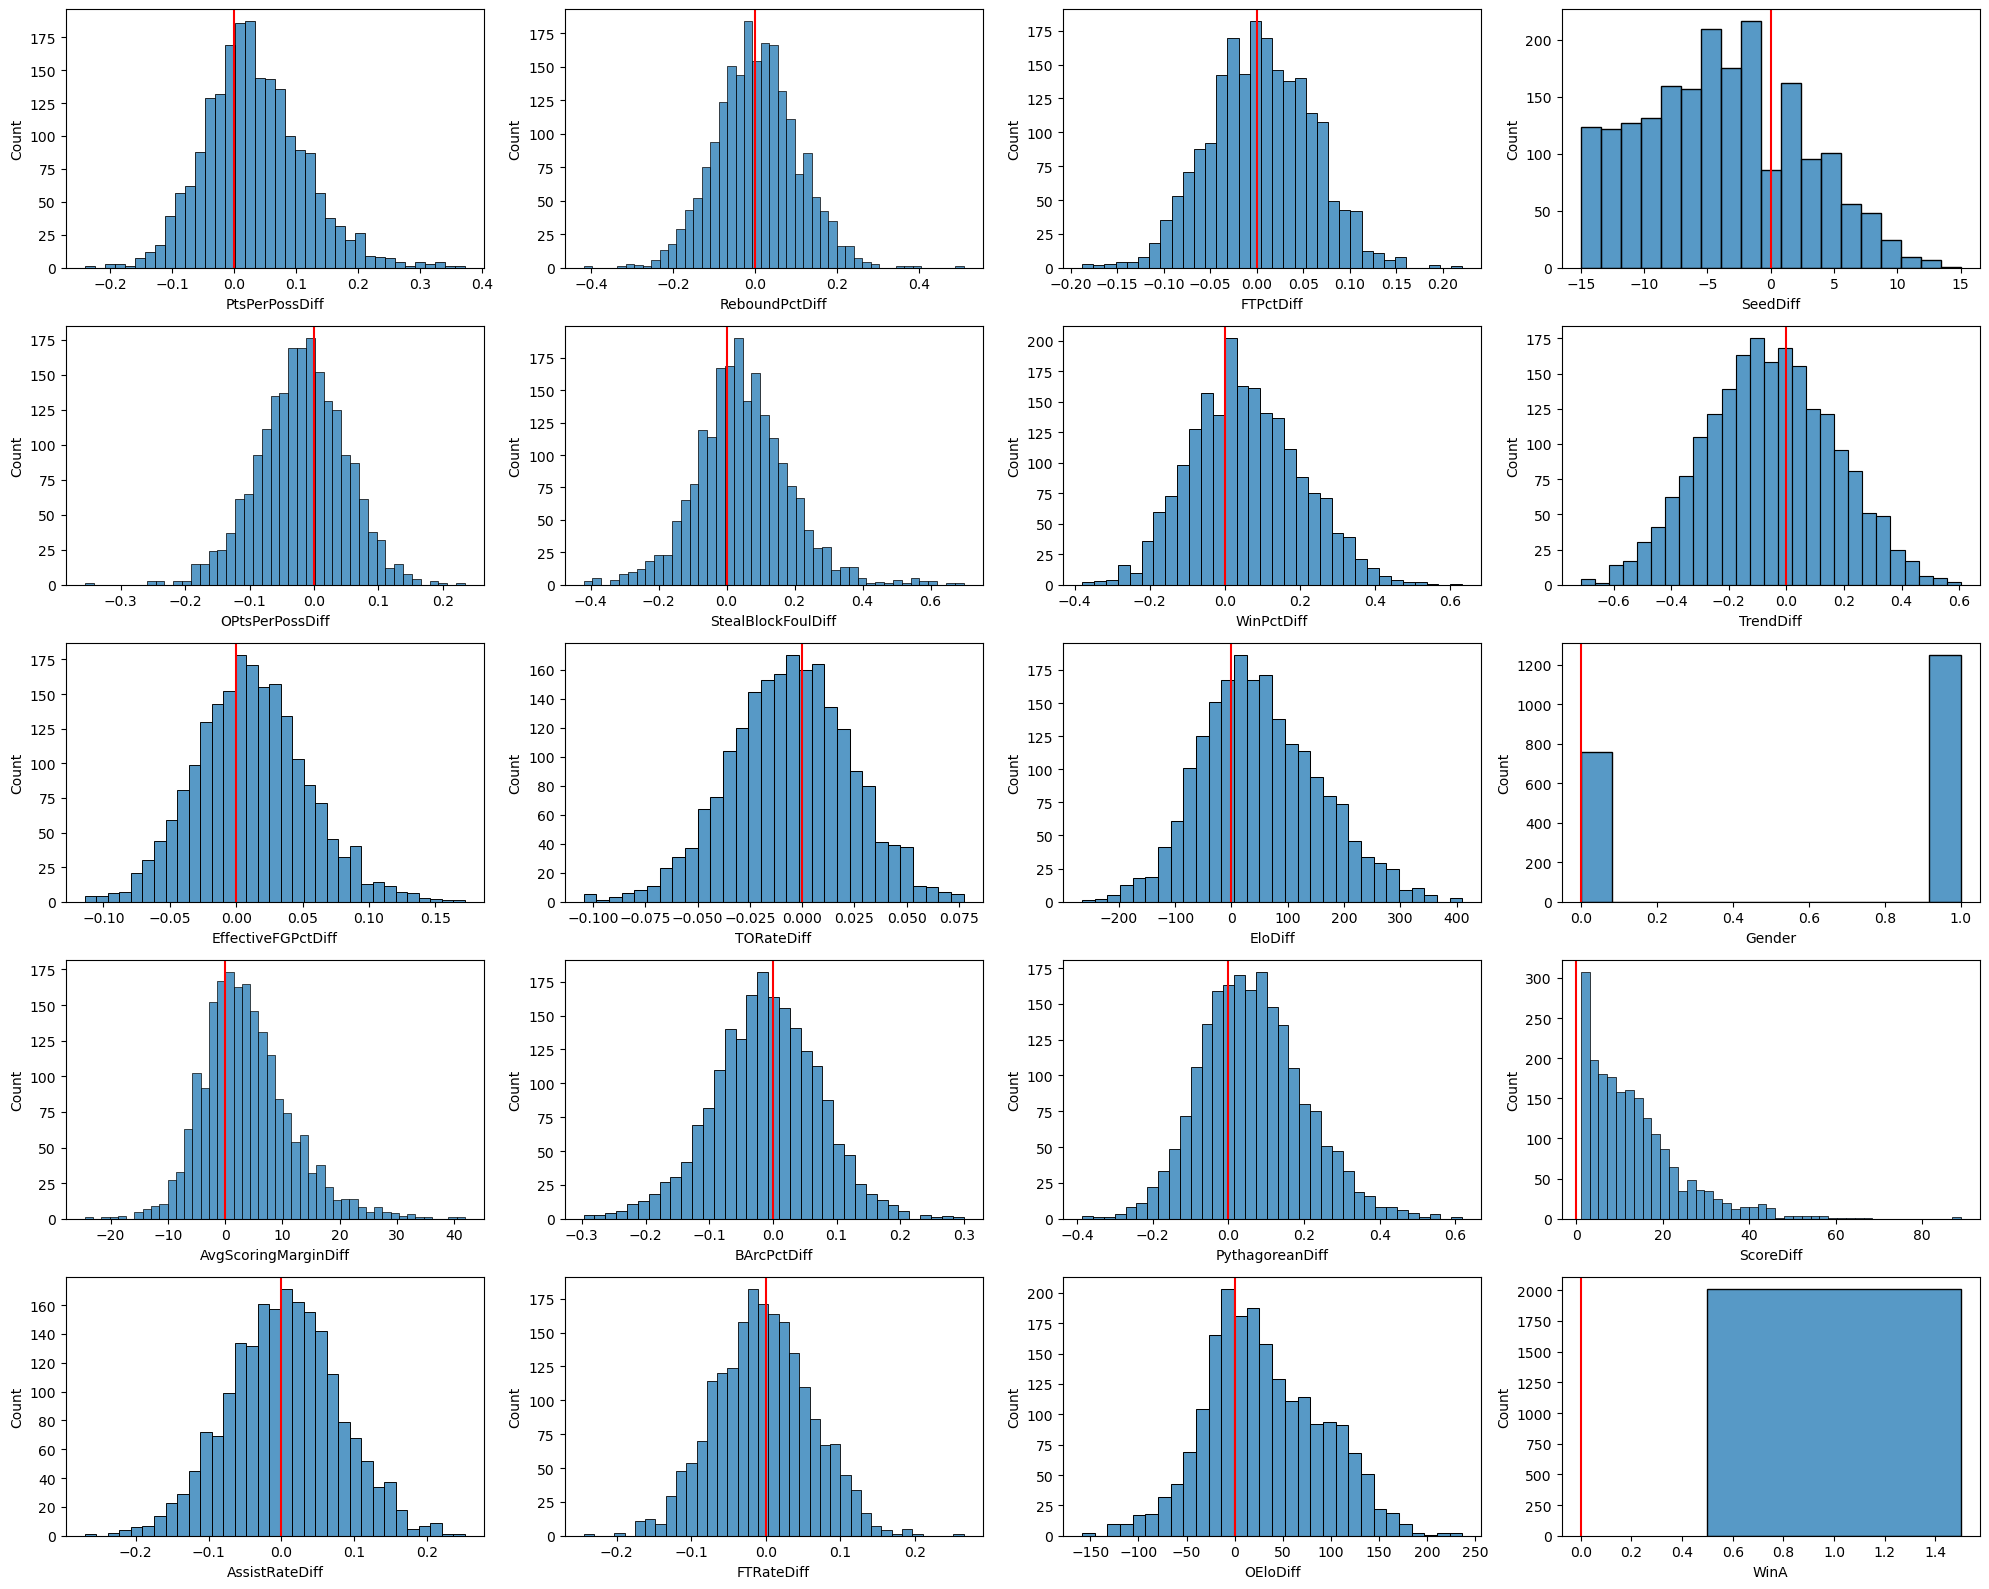

In [43]:
n_rows = 5; n_cols = 4
figs, axs = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=True, figsize=(20, 16))

row = 0; col = 0
for feature in df_tourney_features.columns:
    sns.histplot(df_tourney_features[feature], ax=axs[row, col])
    axs[row, col].set_xlabel(feature)
    axs[row, col].axvline(0, color='red')
    row += 1
    if row == n_rows:
        row = 0
        col += 1

plt.tight_layout()
plt.show()

## Scaling variables

In [44]:
def standard_scale(features, df_train, df_val, df_test=None):    
    mm = MinMaxScaler() 
    
    df_train[features] = pd.DataFrame(mm.fit_transform(df_train[features]), columns = features)
    df_val[features] = pd.DataFrame(mm.transform(df_val[features]), columns = features)
    
    if df_test is not None:
        df_test[features] = pd.DataFrame(mm.transform(df_test[features]), columns = features)
    
    return df_train, df_val, df_test

## Correlation check for variables

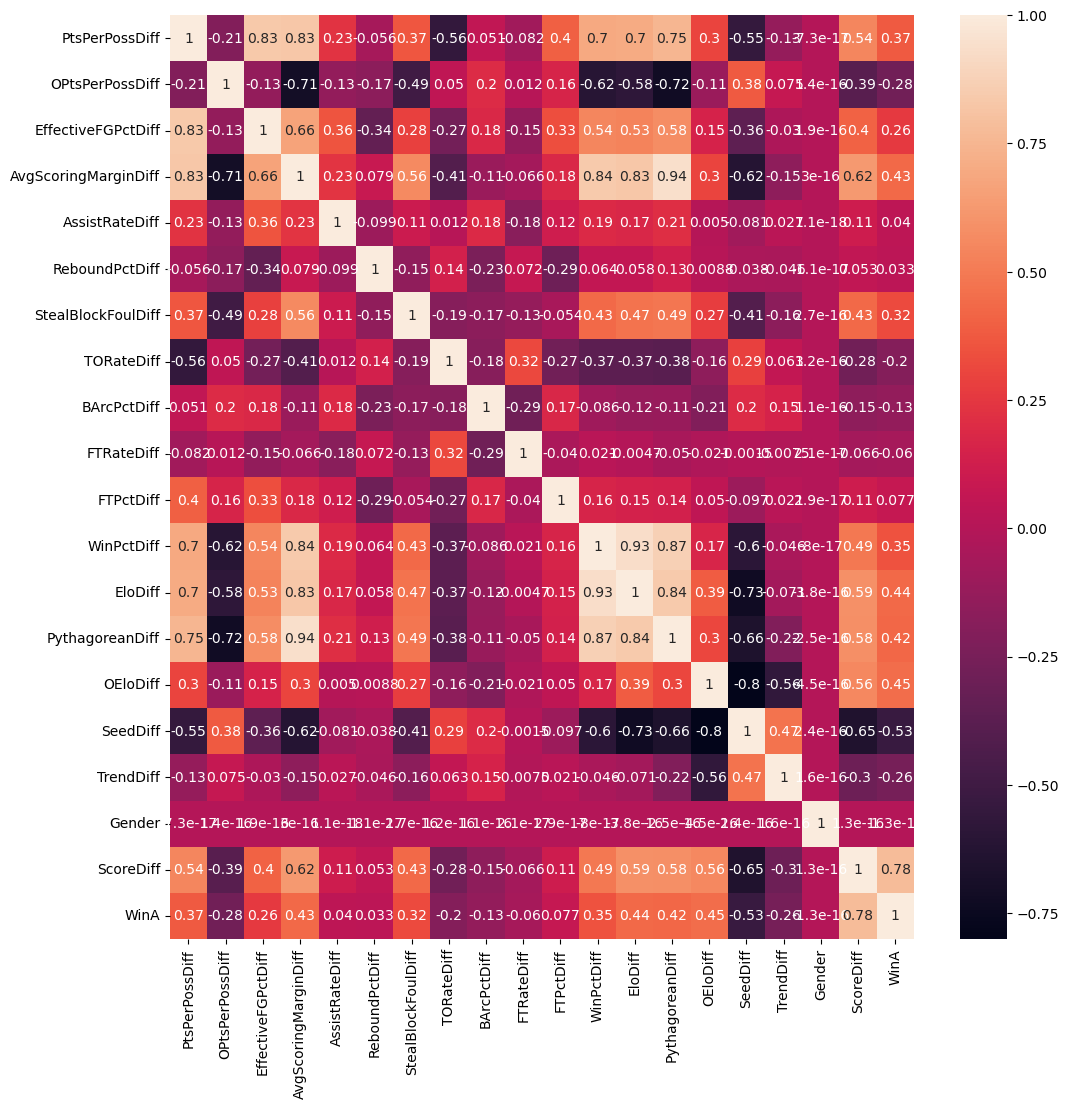

In [45]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(df_tourney_features_combined.corr(), annot=True)
plt.show()

## Mutual Information Scores

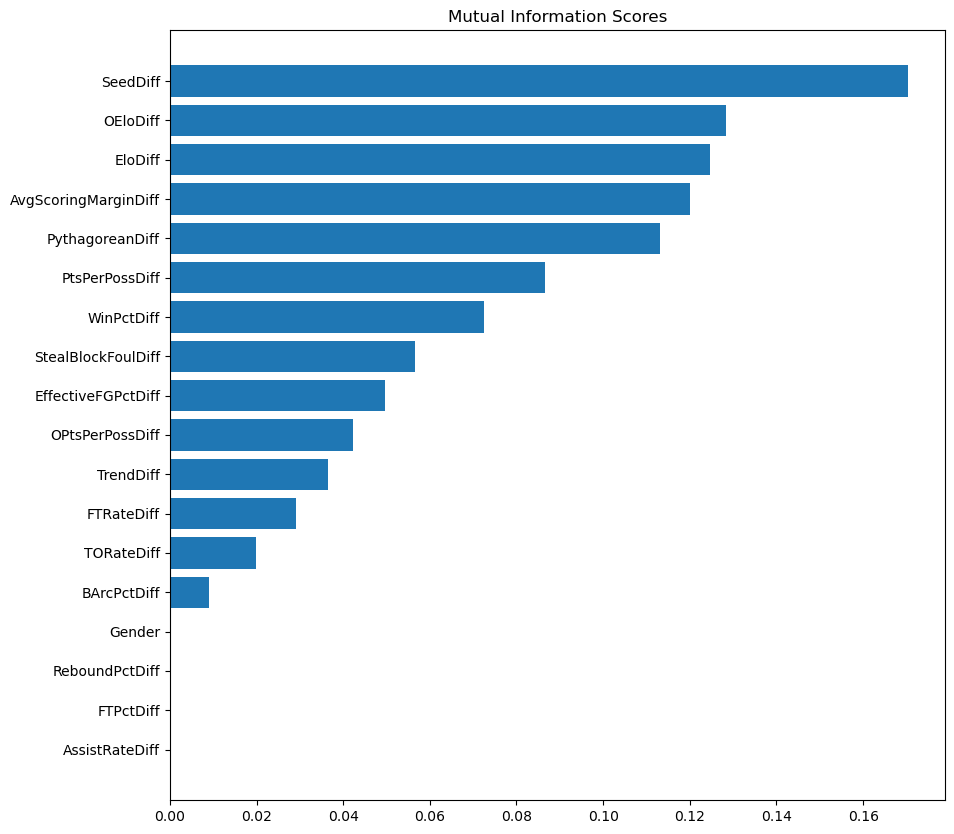

In [46]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

X_mi = df_tourney_features_combined.drop(['WinA', 'ScoreDiff'], axis=1)
y_mi = df_tourney_features_combined['WinA']
mi_scores = make_mi_scores(X_mi, y_mi)
f, ax = plt.subplots(figsize=(10, 10))
plot_mi_scores(mi_scores)

### Eliminate features with low mutual information scores

In [47]:
features = ['SeedDiff', 'OEloDiff', 'EloDiff', 'AvgScoringMarginDiff', 'PythagoreanDiff', 'PtsPerPossDiff', 'WinPctDiff', \
            'StealBlockFoulDiff', 'EffectiveFGPctDiff', 'OPtsPerPossDiff', 'TrendDiff', 'FTRateDiff', 'TORateDiff', 'BArcPctDiff']

target = ['WinA']


### Create feature and target variables

In [48]:
X = df_tourney_features_combined[features]
y = df_tourney_features_combined[target].values

In [49]:
df_tourney_features_combined.head()

PtsPerPossDiff  OPtsPerPossDiff  EffectiveFGPctDiff  \
Season TeamA TeamB                                                        
2003   1421  1411        -0.021731         0.121267           -0.013235   
       1112  1436         0.081979        -0.040629            0.022900   
       1113  1272         0.040148         0.053792            0.018997   
       1141  1166        -0.040490         0.086005            0.005381   
       1143  1301        -0.020811        -0.025797           -0.010092   

                    AvgScoringMarginDiff  AssistRateDiff  ReboundPctDiff  \
Season TeamA TeamB                                                         
2003   1421  1411              -9.208046       -0.049796       -0.052508   
       1112  1436              10.309113        0.011455       -0.080120   
       1113  1272              -1.896552       -0.056567        0.026745   
       1141  1166              -8.805643        0.005290       -0.001809   
       1143  1301               0.324138       -0.016667       -0.010608   

                    StealBlockFoulDiff  TORateDiff  BArcPctDiff  FTRateDiff  \
Season TeamA TeamB                                                            
2003   1421  1411             0.030118    0.012144    -0.016192   -0.152277   
       1112  1436             0.043079   -0.022759     0.026575    0.031691   
       1113  1272            -0.129360    0.006999    -0.113703    0.071937   
       1141  1166            -0.141384    0.061465    -0.011550    0.127689   
       1143  1301            -0.014987   -0.011825    -0.133402   -0.039185   

                    FTPctDiff  WinPctDiff     EloDiff  PythagoreanDiff  \
Season TeamA TeamB                                                       
2003   1421  1411    0.152397   -0.151724  -31.089787        -0.239112   
       1112  1436    0.051446    0.237685  168.162796         0.185614   
       1113  1272    0.047369   -0.172414 -110.976077        -0.050417   
       1141  1166    0.073034   -0.085684  -36.084611        -0.186408   
       1143  1301   -0.089516    0.124138   15.583297         0.005300   

                      OEloDiff  SeedDiff  TrendDiff  Gender  ScoreDiff  WinA  
Season TeamA TeamB                                                            
2003   1421  1411    84.953190         0   0.276776       1          8     1  
       1112  1436   108.248232       -15  -0.153021       1         29     1  
       1113  1272    46.858566         3  -0.337614       1         13     1  
       1141  1166    -6.698033         5   0.350451       1          6     1  
       1143  1301    -9.782263        -1   0.053627       1          2     1

## Create X_test

In [50]:
sample_submission = data['SampleSubmission2023'].copy()

In [51]:
sample_submission['Season'] = sample_submission['ID'].apply(lambda x: x.split('_')[0])
sample_submission['TeamA'] = sample_submission['ID'].apply(lambda x: x.split('_')[1])
sample_submission['TeamB'] = sample_submission['ID'].apply(lambda x: x.split('_')[2])

In [52]:
df_test_statistics = all_statistics.reset_index().copy()
df_test_statistics = df_test_statistics[df_test_statistics['Season'] == '2023'].reset_index(drop=True)


In [53]:
test_teamA_stats = sample_submission.merge(df_test_statistics, left_on=['Season', 'TeamA'], right_on=['Season', 'level_1'])
test_teamB_stats = sample_submission.merge(df_test_statistics, left_on=['Season', 'TeamB'], right_on=['Season', 'level_1'])

In [54]:
test_teamA_stats = test_teamA_stats.merge(df_seeds, left_on=['Season', 'TeamA'], right_on=['Season', 'TeamID'], how='left')
test_teamB_stats = test_teamB_stats.merge(df_seeds, left_on=['Season', 'TeamB'], right_on=['Season', 'TeamID'], how='left')

In [55]:
merged_test_team_stats = test_teamA_stats.merge(test_teamB_stats, on=['Season', 'TeamA', 'TeamB'], suffixes=['_A', '_B'])
merged_test_team_stats['Seed_A'].fillna(17, inplace=True)
merged_test_team_stats['Seed_B'].fillna(17, inplace=True)

In [56]:
merged_test_team_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130683 entries, 0 to 130682
Data columns (total 45 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID_A                130683 non-null  object 
 1   Pred_A              130683 non-null  float64
 2   Season              130683 non-null  object 
 3   TeamA               130683 non-null  object 
 4   TeamB               130683 non-null  object 
 5   level_1_A           130683 non-null  object 
 6   Pythagorean_A       130683 non-null  float64
 7   Elo_A               130683 non-null  float64
 8   WinPct_A            130683 non-null  float64
 9   AvgScoringMargin_A  130683 non-null  float64
 10  PtsPerPoss_A        130683 non-null  float64
 11  OPtsPerPoss_A       130683 non-null  float64
 12  EffectiveFGPct_A    130683 non-null  float64
 13  AssistRate_A        130683 non-null  float64
 14  ReboundPct_A        130683 non-null  float64
 15  TORate_A            130683 non-nul

In [57]:
X_test = pd.DataFrame()
final_features = ['Seed', 'Pythagorean', 'Elo', 'OElo', 'WinPct', 'AvgScoringMargin', 'PtsPerPoss',
                  'OPtsPerPoss', 'EffectiveFGPct', 'TORate', 'BArcPct', 'FTRate', 'StealBlockFoul', 'Trend']

for feature in final_features:
    X_test[feature + 'Diff'] = merged_test_team_stats[feature + '_A'] - merged_test_team_stats[feature + '_B']

In [58]:
X_test.tail()

,SeedDiff,PythagoreanDiff,EloDiff,OEloDiff,WinPctDiff,AvgScoringMarginDiff,PtsPerPossDiff,OPtsPerPossDiff,EffectiveFGPctDiff,TORateDiff,BArcPctDiff,FTRateDiff,StealBlockFoulDiff,TrendDiff
130678,0.0,-0.170240,-46.649981,38.545058,-0.093407,-8.365385,-0.091289,0.022014,-0.056052,-0.006891,-0.072996,0.073421,-0.032336,-0.470186
130679,0.0,-0.216117,-131.218723,-4.289715,-0.213942,-9.615385,-0.102945,0.055823,-0.043172,-0.019841,0.044211,-0.073276,-0.211361,-0.209915
130680,0.0,0.084302,40.003426,19.670258,0.060440,2.788462,-0.036530,-0.079781,-0.006533,0.053814,-0.078455,0.096932,0.037715,-0.260125
130681,0.0,0.038426,-44.565317,-23.164516,-0.060096,1.538462,-0.048186,-0.045973,0.006347,0.040864,0.038753,-0.049765,-0.141310,0.000147
130682,0.0,-0.045876,-84.568743,-42.834773,-0.120536,-1.250000,-0.011656,0.033809,0.012880,-0.012950,0.117208,-0.146698,-0.179025,0.260272


In [59]:
X_test['Season'] = merged_test_team_stats['ID_A'].apply(lambda x: x.split('_')[0]).values
X_test['TeamA'] = merged_test_team_stats['ID_A'].apply(lambda x: x.split('_')[1]).values
X_test['TeamB'] = merged_test_team_stats['ID_A'].apply(lambda x: x.split('_')[2]).values

In [60]:
X_test.fillna(0, inplace=True)

In [61]:
X_test.set_index(['Season', 'TeamA', 'TeamB'], inplace=True)

## Check yourself before you wreck yourself: Plot X_test variables

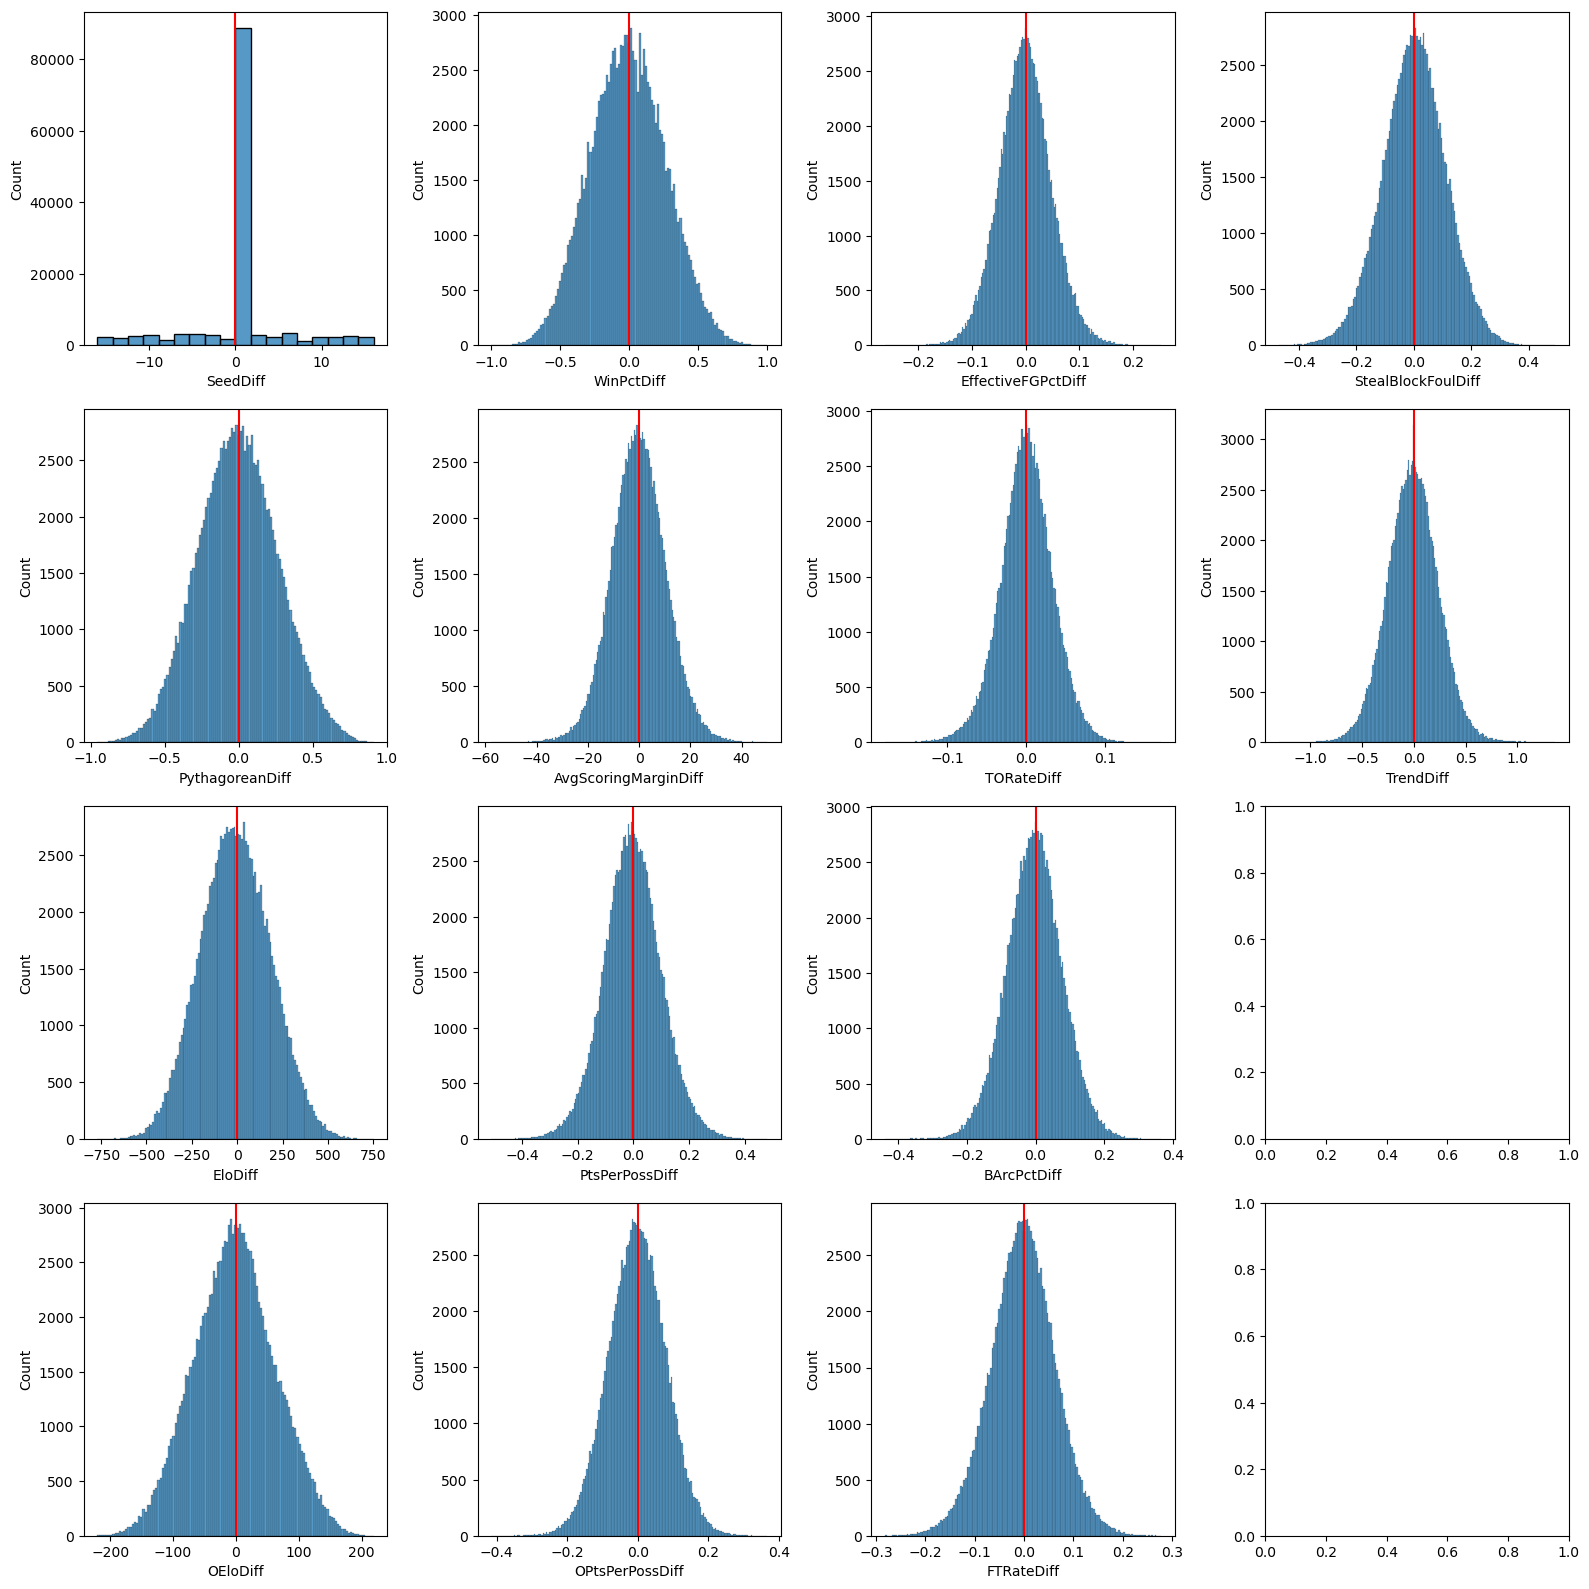

In [62]:
n_rows = 4; n_cols = 4
figs, axs = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=True, figsize=(16, 16))

row = 0; col = 0
for feature in X_test.columns:
    sns.histplot(X_test[feature], ax=axs[row, col])
    axs[row, col].set_xlabel(feature)
    axs[row, col].axvline(0, color='red')
    row += 1
    if row == n_rows:
        row = 0
        col += 1

plt.tight_layout()
plt.show()

## Throwing the Kitchen Sink: Modeling Time

In [63]:
X.loc[:, 'Gender'] = df_tourney_features_combined.loc[:, 'Gender']
X.loc[:, 'WinA'] = df_tourney_features_combined.loc[:, 'WinA']

/tmp/ipykernel_32/250947939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'Gender'] = df_tourney_features_combined.loc[:, 'Gender']
/tmp/ipykernel_32/250947939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'WinA'] = df_tourney_features_combined.loc[:, 'WinA']


In [64]:
X_trimmed = X.reset_index()[(X.reset_index()['Season'].astype(int) >= 2003) & (X.reset_index()['Season'].astype(int) <= 2016)]

X_trimmed.set_index(['Season', 'TeamA', 'TeamB'], inplace=True)
y_trimmed = X_trimmed['WinA'].values

In [65]:
groups = X_trimmed.reset_index()['Gender'].astype(str) + '_' + \
         X_trimmed.reset_index()['Season'].astype(str)
gss = GroupShuffleSplit(n_splits=5, test_size=.2)
X_trimmed.drop(['WinA', 'Gender'], axis=1, inplace=True)
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X_trimmed[features]))
X_scaled.set_index(groups, inplace=True)

In [66]:
# Select only seasons 2003-2016 to prevent data leakage (we're validating on seasons 2017-2022).

In [67]:
'''
def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 32),
        learning_rate=trial.suggest_float("learning_rate", 0, 1),
        n_estimators=30,
        min_child_weight=trial.suggest_int("min_child_weight", 1, 20),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.01, 1),
        colsample_bynode=trial.suggest_float("colsample_bynode", 0.01, 1),
        colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.01, 1),
        max_delta_step=trial.suggest_int("max_delta_step", 1, 20),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e-1, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e0, 1e3, log=True),
        gamma=trial.suggest_float("gamma", 1e-6, 1, log=True)
        
    )
    return score_dataset(X_scaled, y, xgb_params)

def score_dataset(X_scaled, y, xgb_params):
    
    classifier = xgb.XGBClassifier(**xgb_params)
    
    score = cross_val_score(classifier, X_scaled, y_trimmed, cv=gss, groups=groups, scoring='neg_brier_score')
    score = -1 * score.mean() + score.std()
    return score

study = optuna.create_study()
study.optimize(objective, n_trials=30)
xgb_params = study.best_params
print(xgb_params)

plot_slice(study)
'''


'\ndef objective(trial):\n    xgb_params = dict(\n        max_depth=trial.suggest_int("max_depth", 2, 32),\n        learning_rate=trial.suggest_float("learning_rate", 0, 1),\n        n_estimators=30,\n        min_child_weight=trial.suggest_int("min_child_weight", 1, 20),\n        colsample_bytree=trial.suggest_float("colsample_bytree", 0.01, 1),\n        colsample_bynode=trial.suggest_float("colsample_bynode", 0.01, 1),\n        colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.01, 1),\n        max_delta_step=trial.suggest_int("max_delta_step", 1, 20),\n        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e-1, log=True),\n        reg_lambda=trial.suggest_float("reg_lambda", 1e0, 1e3, log=True),\n        gamma=trial.suggest_float("gamma", 1e-6, 1, log=True)\n        \n    )\n    return score_dataset(X_scaled, y, xgb_params)\n\ndef score_dataset(X_scaled, y, xgb_params):\n    \n    classifier = xgb.XGBClassifier(**xgb_params)\n    \n    score = cross_val_score(classifier,

In [68]:
# fig = optuna.visualization.plot_param_importances(study)
# fig.show()

In [69]:
def objective(trial):
    lgbm_params = {
        'reg_alpha': trial.suggest_float("reg_alpha", 1e-6, 1e2, log=True),
        'reg_lambda': trial.suggest_float("reg_lambda", 1e0, 1e3, log=True),
        'num_leaves': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'learning_rate': trial.suggest_float("learning_rate", 0, 1),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0, 1),
        'n_estimators': 30,
    }
    return score_dataset(X_scaled, y, lgbm_params)

def score_dataset(X_scaled, y, lgbm_params):
    
    classifier = lgb.LGBMClassifier(**lgbm_params, class_weight='balanced')
    
    score = cross_val_score(classifier, X_scaled, y_trimmed, cv=gss, groups=groups, scoring='neg_brier_score')
    score = -1 * score.mean() + score.std()
    return score

study = optuna.create_study()
study.optimize(objective, n_trials=100)
lgbm_params = study.best_params
print(lgbm_params)

plot_slice(study)

[I 2023-06-21 06:10:38,541] A new study created in memory with name: no-name-4279de2d-1cb0-4f1e-bfda-94a97aef0fc1
[I 2023-06-21 06:10:38,795] Trial 0 finished with value: 0.19379866800633905 and parameters: {'reg_alpha': 65.84172747028434, 'reg_lambda': 21.96535187749677, 'max_depth': 12, 'learning_rate': 0.4085697064482928, 'colsample_bytree': 0.25540934700074835, 'colsample_bynode': 0.7273381065426727}. Best is trial 0 with value: 0.19379866800633905.
[I 2023-06-21 06:10:39,844] Trial 1 finished with value: 0.19225741068316074 and parameters: {'reg_alpha': 5.437667794088992e-05, 'reg_lambda': 16.49787768729026, 'max_depth': 29, 'learning_rate': 0.19275445848905026, 'colsample_bytree': 0.36488541869331825, 'colsample_bynode': 0.7634411081241597}. Best is trial 1 with value: 0.19225741068316074.
[I 2023-06-21 06:10:40,310] Trial 2 finished with value: 0.18864433501301972 and parameters: {'reg_alpha': 0.002742268479301236, 'reg_lambda': 531.5133760188535, 'max_depth': 21, 'learning_rate

{'reg_alpha': 2.9713473728996243, 'reg_lambda': 1.9105732891811755, 'max_depth': 28, 'learning_rate': 0.17861108398845488, 'colsample_bytree': 0.5719328516048949, 'colsample_bynode': 0.7019662961037085}


In [70]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [71]:
def kfold_reg(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    features = ['SeedDiff', 'OEloDiff', 'EloDiff', 'AvgScoringMarginDiff', 'PythagoreanDiff', 'PtsPerPossDiff', 'OPtsPerPossDiff', 'WinPctDiff', \
               'EffectiveFGPctDiff', 'StealBlockFoulDiff', 'FTRateDiff', 'TORateDiff', 'BArcPctDiff', 'TrendDiff']
    
    for season in seasons[14:]:
        if verbose:
            print(f'\nValidating on season {season}')
        else:
            print(f'\nTesting on season {season}')
        
        current_season = int(season)
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.reset_index(drop=True).copy()
        
        df_train, df_val, df_test = standard_scale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            logistic = LogisticRegression(C=100, max_iter=10000, class_weight='balanced')
            lsvc = LinearSVC(max_iter=10000, class_weight='balanced', fit_intercept=False) 
            # I snuck this in because it did really well in validation testing.
            # xgbc = xgb.XGBClassifier(**xgb_params)
            lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight='balanced')
            stacked = StackingClassifier(estimators=[
                                                     ('LinearSVC', lsvc),
                                                     #('XGBoost', xgbc),
                                                     ('LightGBM', lgbm),
                                                     ], 
                                                     final_estimator=logistic, 
                                                     n_jobs=-1)
            model = stacked
            
        model.fit(df_train[features], df_train[target])
        calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5) 
        calibrated.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = calibrated.predict_proba(df_val[features])[:, 1]
            # pred = (pred - pred.min()) / (pred.max() - pred.min())
            
        if df_test is not None:
            if mode == "reg":
                pred = model.predict(df_test[features])
            else:
                pred_test = calibrated.predict_proba(df_test[features])[:, 1]
                # pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min()) 
                    
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()

        if verbose:
            loss = ((df_val['WinA'].values - pred) ** 2).mean()
            cvs.append(loss)
            print(f'\t -> Scored {loss:.4f}')
        
    print(f'\n Local CV is {np.mean(cvs):.4f}')
    
    return pred_tests


Validating on season 2017


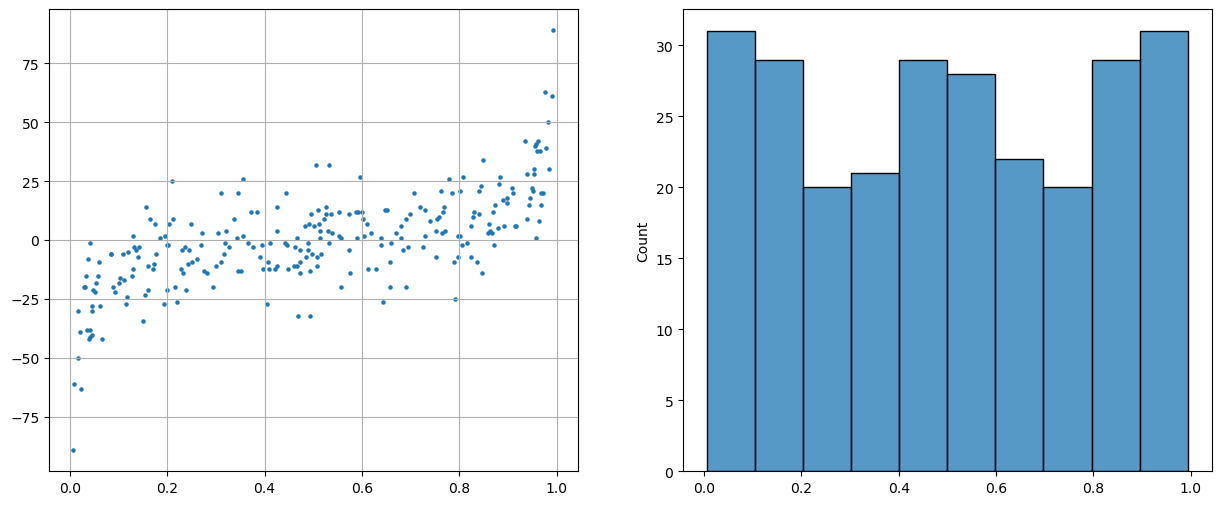

	 -> Scored 0.1625

Validating on season 2018


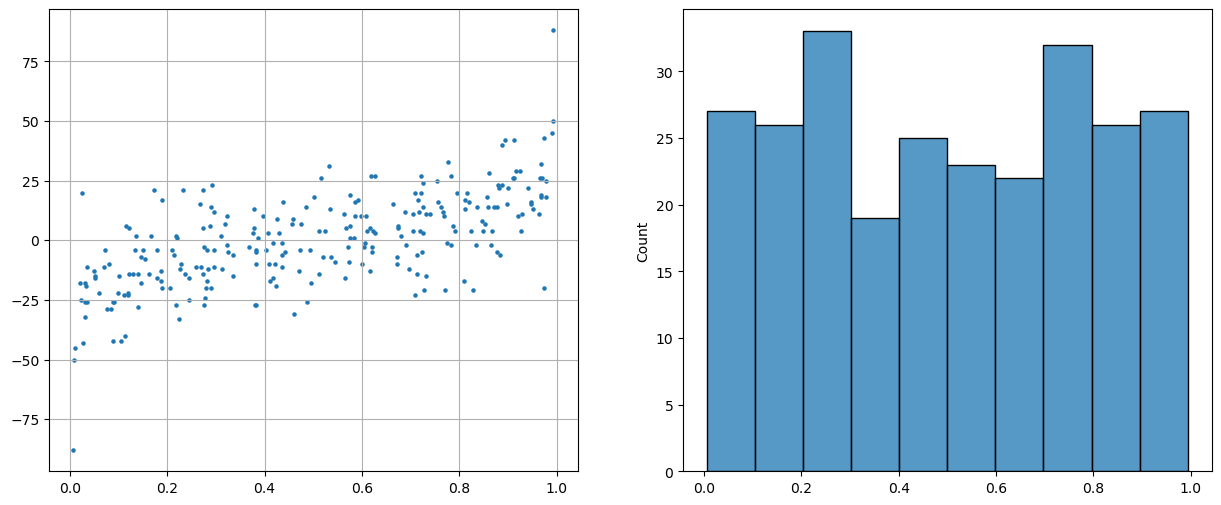

	 -> Scored 0.1786

Validating on season 2019


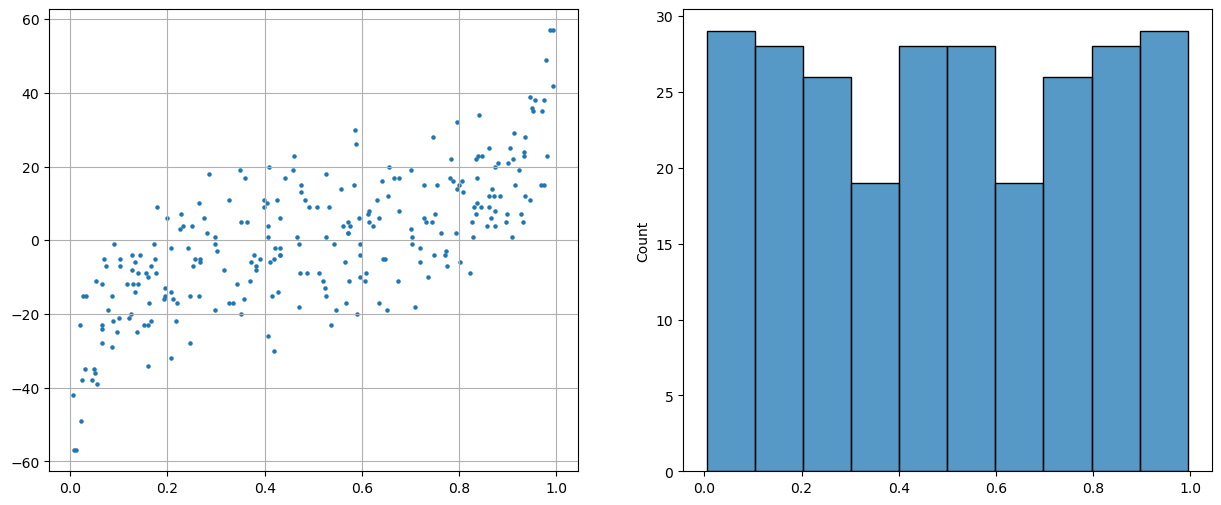

	 -> Scored 0.1498

Validating on season 2021


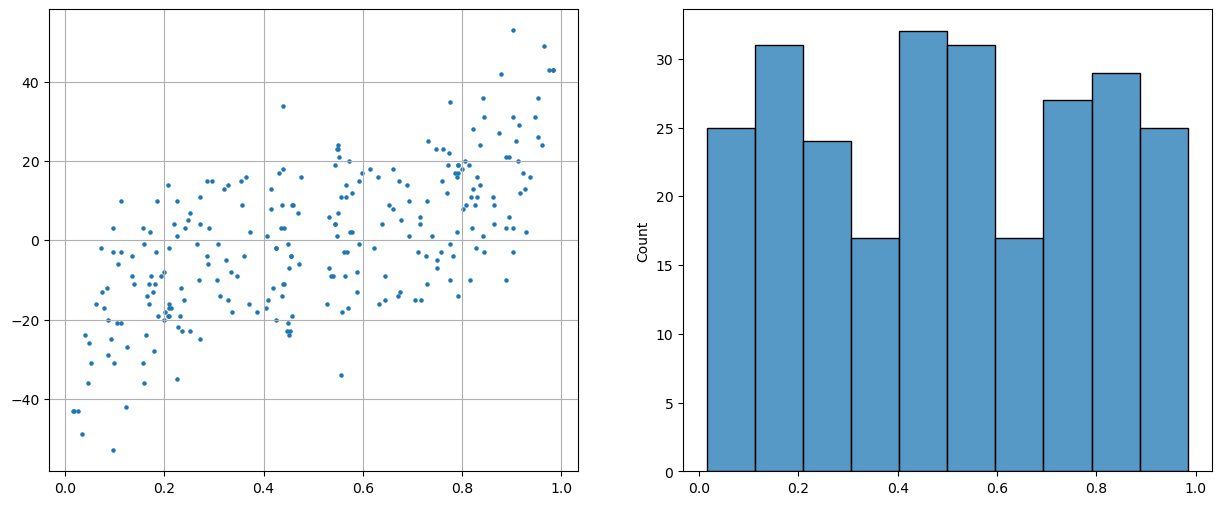

	 -> Scored 0.1840

Validating on season 2022


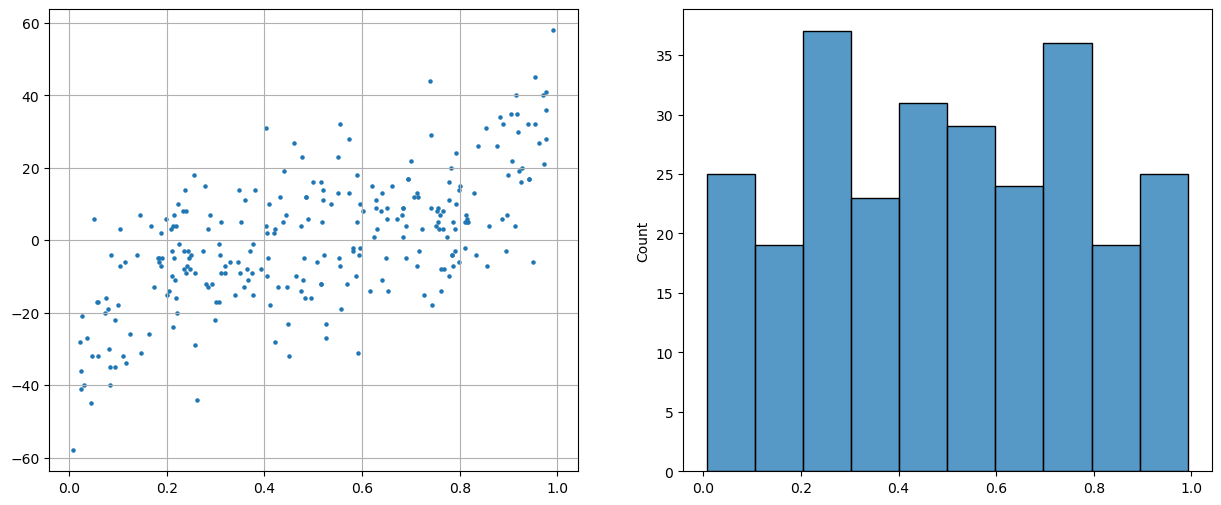

	 -> Scored 0.1903

 Local CV is 0.1730


In [72]:
X = df_tourney_features_combined.reset_index()

pred_tests = kfold_reg(X, X_test, plot=True, verbose=1, mode="cls")

In [73]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 130683 entries, ('2023', '1101', '1102') to ('2023', '3476', '3477')
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SeedDiff              130683 non-null  float64
 1   PythagoreanDiff       130683 non-null  float64
 2   EloDiff               130683 non-null  float64
 3   OEloDiff              130683 non-null  float64
 4   WinPctDiff            130683 non-null  float64
 5   AvgScoringMarginDiff  130683 non-null  float64
 6   PtsPerPossDiff        130683 non-null  float64
 7   OPtsPerPossDiff       130683 non-null  float64
 8   EffectiveFGPctDiff    130683 non-null  float64
 9   TORateDiff            130683 non-null  float64
 10  BArcPctDiff           130683 non-null  float64
 11  FTRateDiff            130683 non-null  float64
 12  StealBlockFoulDiff    130683 non-null  float64
 13  TrendDiff             130683 non-null  float64
dtypes: float64(

## Predict on Test Set

In [74]:
pred_test = np.mean(pred_tests, 0)

## Prepare for automatic submission

In [75]:
final_submission = pd.DataFrame()
final_submission.index = merged_test_team_stats['ID_A']
final_submission.index.rename('ID', inplace=True)
final_submission['Pred'] = pred_test
final_submission.to_csv('submission.csv')

## Check yourself before you wreck yourself part II: Probability Histogram

Pred    0.498309
dtype: float64


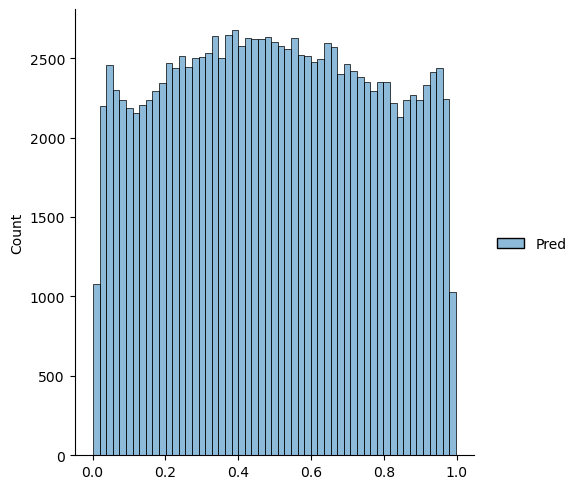

In [76]:
_ = sns.displot(final_submission)
print(final_submission.mean())